In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(42)

In [14]:
def lorenz_system(state, t = 0): #state : the current position in 3D space
# Essentially this function tells us the velocity at which this point is moving 

    x, y, z = state
    
    # Lorenz parameters that produce butterfly pattern
    sigma = 10.0
    rho = 28.0
    beta = 8.0/3.0
    
    # Lorenz equations 
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    
    return np.array([dx_dt, dy_dt, dz_dt])

def runge_kutta_adapted(f, y0, t_span, dt, args):
    
    t_start, t_end = t_span
    t = np.arange(t_start, t_end, dt) #creating the time points array , 't' is of the form [0.00, 0.01, 0.02, 0.03 .....699.99]
    n_steps = len(t) #number of time steps 
    n_vars = len(y0) #number of variables (3)
    
    # Initialize solution array
    y = np.zeros((n_steps, n_vars)) #Initial condition with all the entries as 0 
    y[0] = y0
    
    # RK4 integration loop
    for i in range(n_steps - 1):
        k1 = dt * f(y[i], t[i], *args) #the slope at the current point
        k2 = dt * f(y[i] + k1/2, t[i] + dt/2,*args) # the slope at the midpoint using k1 
        k3 = dt * f(y[i] + k2/2, t[i] + dt/2,*args) #A refined slope at the midpoint using k2
        k4 = dt * f(y[i] + k3, t[i] + dt,*args) #The slope at thend endpoint using k3
        
        y[i+1] = y[i] + (k1 + 2*k2 + 2*k3 + k4) / 6 # (1:2:2:1) 
    
    return y

def listening_reservoir (self,r, u, dt, M,gamma, input_strength,W_in ):
    

    # dr/dt = γ[-r + tanh(M·r + σ·W_in·u)] 
    
    #n_listen = int(t_listen / dt) #time steps 
    #n_total = u.shape[0]
    
    # Initialize reservoir state
    #r = np.zeros(self.N)
    
    #for i in range(1, n_total):
        # Current input
    u_current = u  #using the previous input to computer the current reservoir state
        
        # Compute dr/dt 
        # dr/dt = gamma * [-r + tanh(M*r + sigma*W_in*u)]
    activation = np.dot(self.M, r) + self.input_strength * np.dot(self.W_in, u_current) # total input to each neuron combines both the internal recurrent activity and the external Lorenz input 
    dr_dt = self.gamma * (-r + np.tanh(activation))
    
    return dr_dt #Reservoir State during listening stage 




    
def runge_kutta_4(f, y0, t_span, dt):
    
    t_start, t_end = t_span
    t = np.arange(t_start, t_end, dt) #creating the time points array , 't' is of the form [0.00, 0.01, 0.02, 0.03 .....699.99]
    n_steps = len(t) #number of time steps 
    n_vars = len(y0) #number of variables (3)
    
    # Initialize solution array
    y = np.zeros((n_steps, n_vars)) #Initial condition with all the entries as 0 
    y[0] = y0
    
    # RK4 integration loop
    for i in range(n_steps - 1):
        k1 = dt * f(y[i], t[i]) #the slope at the current point
        k2 = dt * f(y[i] + k1/2, t[i] + dt/2) # the slope at the midpoint using k1 
        k3 = dt * f(y[i] + k2/2, t[i] + dt/2) #A refined slope at the midpoint using k2
        k4 = dt * f(y[i] + k3, t[i] + dt) #The slope at thend endpoint using k3
        
        y[i+1] = y[i] + (k1 + 2*k2 + 2*k3 + k4) / 6 # (1:2:2:1) 
    
    return t, y

# Generate Lorenz attractor data/Training Data
dt = 0.01  # Time step 
t_total = 700  # Total simulation time (listening + training + testing)
initial_condition = [1.0, 1.0, 1.0] 

t, lorenz_data = runge_kutta_4(lorenz_system, initial_condition, (0, t_total), dt) 

print(f"Generated {len(t)} time points")
print(f"Lorenz data shape: {lorenz_data.shape}")

Generated 70000 time points
Lorenz data shape: (70000, 3)


In [20]:
def listening_stage(f, y0, t_span, r, u, dt, t_listen, M,gamma, input_strength,W_in ):
    for i in range(0,t_listen):
        args = [u[i],M,gamma, input_strength,W_in]
        r = runge_kutta_adapted(listening_reservoir , r, t_span, dt, args)
    return r 
    
def training_stage(f, y0, t_span, r, u, dt, t_listen, t_train, M,gamma, input_strength,W_in ):
    r_stored = []
    for i in range(t_listen, t_train):
        args = [u[i],M,gamma, input_strength,W_in ]
        r = runge_kutta_adapted(listening_reservoir , r, t_span, dt, args)
        r_stored.append(r)
    r_stored = np.array(r_stored)
    
    return r,r_stored

In [21]:
class ReservoirComputer:
    
    def __init__(self, N=100, D=3, spectral_radius=0.6, sparsity=0.05, 
                 input_strength=0.2, gamma=10, beta=1e-4):
        
        self.N = N # N=100: Number of neurons in our reservoir (the "pond" that processes information)
        self.D = D #D=3: Input dimension (x, y, z from Lorenz system)
        self.spectral_radius = spectral_radius #it controls the reservoir's "memory"
        self.sparsity = sparsity #Only 5% of possible neuron connections actually exist
        self.input_strength = input_strength # How strongly external input affects the reservoir : sigma
        self.gamma = gamma #Time scale parameter (how quickly reservoir responds)
        self.beta = beta #Ridge Regularization parameter to prevent overfitting
        
        # Initialize matrices
        self._initialize_matrices()
        
    def _initialize_matrices(self):
        """
        Initialize the adjacency matrix M and input matrix W_in.
        Following Erdős-Rényi topology 
        """
        # Create adjacency matrix M with Erdős-Rényi topology
        # Each element has probability 'sparsity' of being non-zero
        # This creates a sparse Random Network where each neuron connects to only about 5% of other neurons
        M = np.random.rand(self.N, self.N)
        M = (M < self.sparsity).astype(float)
        
        # Replace non-zero elements with random values from (-1, 1)
        non_zero_mask = M != 0 
        M[non_zero_mask] = np.random.uniform(-1, 1, np.sum(non_zero_mask))
        
        # Scale the matrix M to desired spectral radius
        eigenvalues = np.linalg.eigvals(M)
        current_spectral_radius = np.max(np.abs(eigenvalues))
        
        if current_spectral_radius != 0:
            M = M * (self.spectral_radius / current_spectral_radius) # M * Scaling Factor 
        
        self.M = M
        
        # Create input matrix W_in (100,3)
        # Each row has only one non-zero element i.e Each neuron receives input exactly from one of the three Lorenz variables chosen randomly
        
        self.W_in = np.zeros((self.N, self.D))
        for i in range(self.N):
            # Randomly choose which input dimension connects to this neuron
            j = np.random.randint(0, self.D)
            # Random weight from (-1, 1)
            self.W_in[i, j] = np.random.uniform(-1, 1)
            
        print(f"Initialized reservoir with spectral radius: {self.spectral_radius}")
        print(f"Sparsity of M: {np.mean(M != 0):.3f}")

In [ ]:
r0 = np.zeroes(N)
r = listening_stage(f, y0, t_span, r0, u, dt, t_listen, M,gamma, input_strength,W_in )

r,r_stored = training_stage(f, y0, t_span, r, u, dt, t_train, M,gamma, input_strength,W_in )

In [16]:
def listening_stage(self, u, dt, t_listen):

    # dr/dt = γ[-r + tanh(M·r + σ·W_in·u)] 
    
    """
    Implements the listening stage where the RC is driven by input u(t).
    
    Parameters:
    -----------
    u : array
        Input signal of shape (n_timesteps, D)
    dt : float
        Integration time step
    t_listen : float
        Duration of listening stage
    
    Returns:
    --------
    r : array
        Reservoir states during listening stage
        Essentially R stores the activity of all 100 neurons at every single time step throughout the entire simulation 
    """
    n_listen = int(t_listen / dt) #time steps 
    n_total = u.shape[0]
    
    # Initialize reservoir state
    r = np.zeros((n_total, self.N))
    
    for i in range(1, n_total):
        # Current input
        u_current = u[i-1] #using the previous input to computer the current reservoir state
        
        # Compute dr/dt 
        # dr/dt = gamma * [-r + tanh(M*r + sigma*W_in*u)]
        activation = np.dot(self.M, r[i-1]) + self.input_strength * np.dot(self.W_in, u_current) # total input to each neuron combines both the internal recurrent activity and the external Lorenz input 
        dr_dt = self.gamma * (-r[i-1] + np.tanh(activation))
        
        # Update state using Euler method 
        # function listening RC : f 
        r[i] = r[i-1] + dt * dr_dt
    
    return r #Reservoir State during listening stage 


# Add this method to the ReservoirComputer class
ReservoirComputer.listening_stage = listening_stage #The reservoir is essentially learning to create a high-dimensional representation of the Lorenz dynamics. 

In [17]:
def train(self, r, u, t_listen, t_train, dt):
    """
    Train the readout matrix using ridge regression.
    
    Parameters:
    -----------
    r : array
        Reservoir states from listening stage
    u : array
        Target output signal
    t_listen : float
        Duration of listening stage
    t_train : float
        Duration of training stage
    dt : float
        Time step
    
    Returns:
    --------
    W_out : array
        Trained readout matrix
    """
    # Convert times to indices
    i_listen = int(t_listen / dt)
    i_train = int(t_train / dt)
    
    # Extract training data (from t_listen to t_train)
    r_train = r[i_listen:i_train]
    u_train = u[i_listen:i_train]
    
    # Implement squaring technique 
    # q(r) = [r; r^2] where r^2 is element-wise square
    r_squared = r_train ** 2
    q_r = np.hstack([r_train, r_squared])  # Shape: (n_samples, 2*N) #Stacking both the arrays horizontally 
    
    # Construct matrices for ridge regression as in Eq. (2.16)
    X = q_r.T  # Response data matrix (2N x n_samples)
    Y = u_train.T  # Input data matrix (D x n_samples)
    
    # Ridge regression formula: W_out = Y * X^T * (X * X^T + beta * I)^(-1)
    # Compute X * X^T
    XX_T = np.dot(X, X.T)
    
    # Add regularization term
    I = np.eye(2 * self.N) #Identity matrix 
    XX_T_reg = XX_T + self.beta * I
    
    # Compute W_out
    W_out = np.dot(np.dot(Y, X.T), np.linalg.inv(XX_T_reg))
    
    self.W_out = W_out
    
    # Split W_out into linear and square parts for analysis
    self.W_out_linear = W_out[:, :self.N]
    self.W_out_square = W_out[:, self.N:]
    
    print(f"Training completed. W_out shape: {W_out.shape}")
    
    return W_out

# Add this method to the ReservoirComputer class
ReservoirComputer.train = train

In [18]:
def predict(self, r_initial, n_predict, dt):
    """
    Autonomous prediction stage - the closed-loop RC.
    
    Parameters:
    -----------
    r_initial : array
        Initial reservoir state (typically the last state from training)
    n_predict : int
        Number of prediction steps
    dt : float
        Time step
    
    Returns:
    --------
    predictions : array
        Predicted outputs
    r_predict : array
        Reservoir states during prediction
    """
    # Initialize arrays
    r_predict = np.zeros((n_predict, self.N))
    predictions = np.zeros((n_predict, self.D))
    
    # Set initial state
    r_predict[0] = r_initial
    
    # Compute initial prediction using readout
    q_r = np.hstack([r_initial, r_initial**2])
    predictions[0] = np.dot(self.W_out, q_r)
    
    # Implement closed-loop dynamics from Eq. (2.19)
    for i in range(1, n_predict):
        # Previous prediction becomes the input
        u_pred = predictions[i-1]
        
        # Compute dr/dt for autonomous system
        activation = np.dot(self.M, r_predict[i-1]) + \
                    self.input_strength * np.dot(self.W_in, u_pred)
        dr_dt = self.gamma * (-r_predict[i-1] + np.tanh(activation))
        
        # Update reservoir state
        r_predict[i] = r_predict[i-1] + dt * dr_dt
        
        # Compute prediction using readout
        q_r = np.hstack([r_predict[i], r_predict[i]**2])
        predictions[i] = np.dot(self.W_out, q_r)
    
    return predictions, r_predict

# Add this method to the ReservoirComputer class
ReservoirComputer.predict = predict

In [7]:
# Create reservoir computer instance
rc = ReservoirComputer(
    N=100,                # Number of neurons
    D=3,                  # Lorenz has 3 dimensions
    spectral_radius=0.6,  # rho
    sparsity=0.05,        # 5% connectivity
    input_strength=0.2,   # sigma parameter
    gamma=10,             # decay rate
    beta=1e-4            # regularization
)

# Define time segments (all in seconds)
t_listen = 100   # Listening stage duration
t_train = 200    # Total training duration (includes listening)
t_predict = 100  # Prediction duration

# Run listening stage
print("Running listening stage...")
r_states = rc.listening_stage(lorenz_data, dt, t_listen)

# Train the readout matrix
print("\nTraining readout matrix...")
W_out = rc.train(r_states, lorenz_data, t_listen, t_train, dt)

# Make predictions
print("\nMaking predictions...")
i_train = int(t_train / dt)
r_initial = r_states[i_train]
n_predict = int(t_predict / dt)

predictions, r_predict = rc.predict(r_initial, n_predict, dt)

print(f"\nPrediction shape: {predictions.shape}")

Initialized reservoir with spectral radius: 0.6
Sparsity of M: 0.049
Running listening stage...

Training readout matrix...
Training completed. W_out shape: (3, 200)

Making predictions...

Prediction shape: (10000, 3)


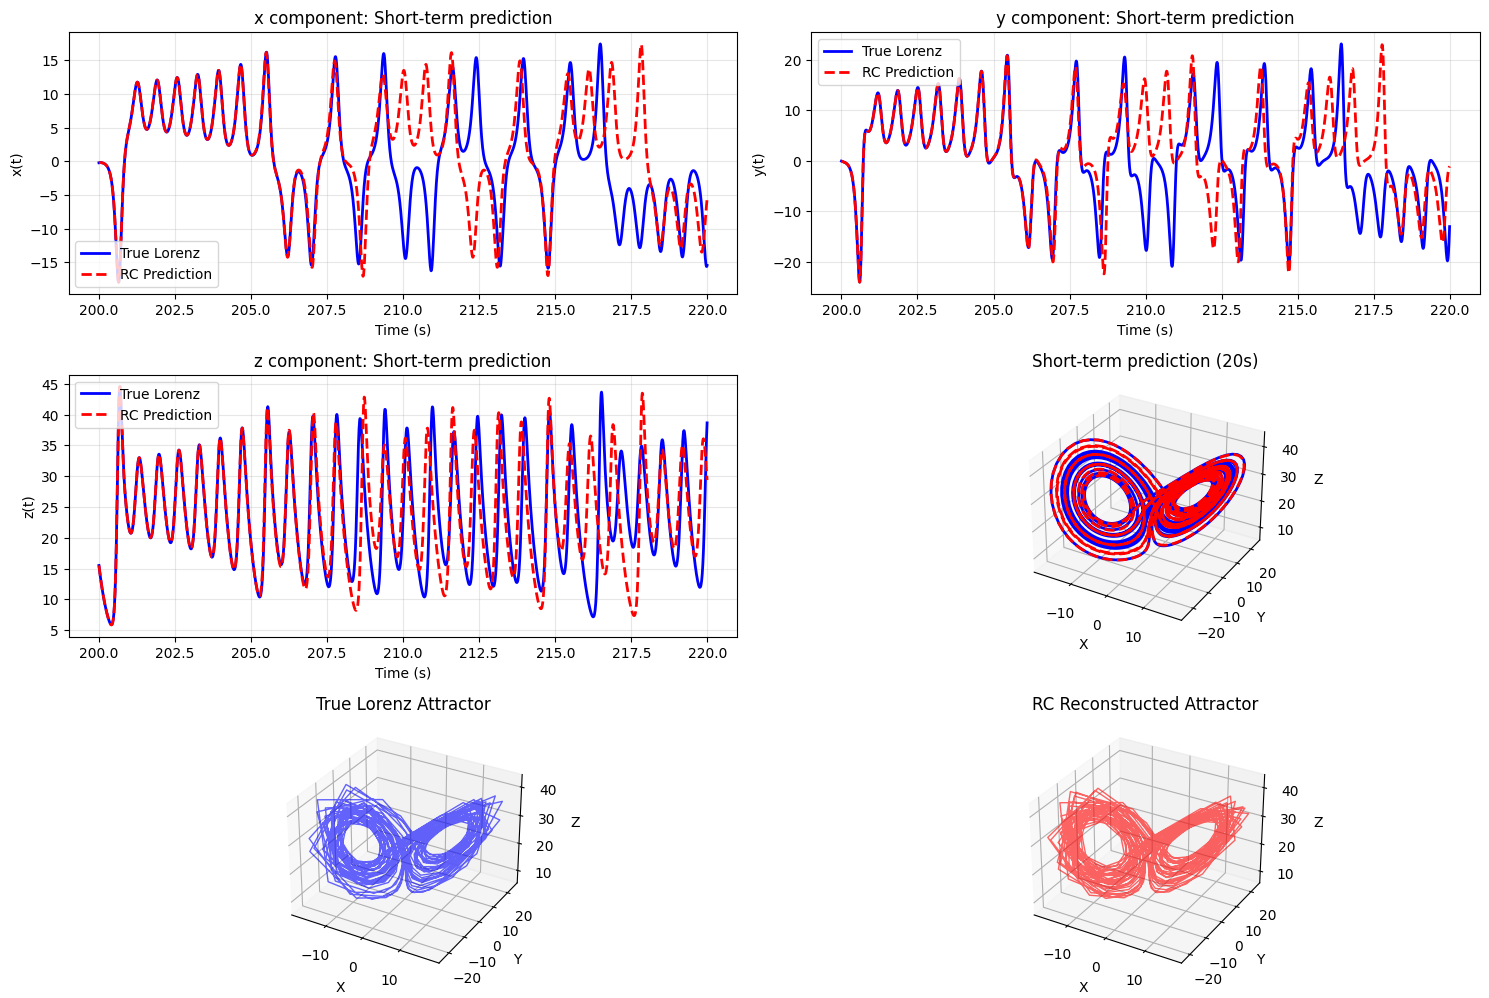


Mean absolute error for first 20s: 4.2047


In [8]:
# Plot comparison of true Lorenz and RC predictions
fig = plt.figure(figsize=(15, 10))

# Time indices for plotting
i_start = int(t_train / dt)
i_end = i_start + int(20 / dt)  # Show 20 seconds of prediction

# Subplot 1-3: Time series comparison
time_true = t[i_start:i_end]
time_pred = t[i_start:i_start+len(time_true)]

for i, label in enumerate(['x', 'y', 'z']):
    plt.subplot(3, 2, i+1)
    plt.plot(time_true, lorenz_data[i_start:i_end, i], 'b-', 
             label='True Lorenz', linewidth=2)
    plt.plot(time_pred, predictions[:len(time_true), i], 'r--', 
             label='RC Prediction', linewidth=2)
    plt.xlabel('Time (s)')
    plt.ylabel(f'{label}(t)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.title(f'{label} component: Short-term prediction')

# Subplot 4: 3D phase space (short-term)
ax1 = fig.add_subplot(3, 2, 4, projection='3d')
ax1.plot(lorenz_data[i_start:i_end, 0], 
         lorenz_data[i_start:i_end, 1], 
         lorenz_data[i_start:i_end, 2], 'b-', linewidth=2)
ax1.plot(predictions[:len(time_true), 0], 
         predictions[:len(time_true), 1], 
         predictions[:len(time_true), 2], 'r--', linewidth=2)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Short-term prediction (20s)')

# Subplot 5-6: Long-term attractor reconstruction
# Use all predictions for long-term behavior
ax2 = fig.add_subplot(3, 2, 5, projection='3d')
# True Lorenz attractor (sample from training data)
sample_true = lorenz_data[int(100/dt):int(150/dt):10]  # Subsample for clarity
ax2.plot(sample_true[:, 0], sample_true[:, 1], sample_true[:, 2], 
         'b-', alpha=0.6, linewidth=1)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('True Lorenz Attractor')

ax3 = fig.add_subplot(3, 2, 6, projection='3d')
# RC reconstructed attractor (use later part of prediction)
sample_pred = predictions[int(50/dt)::10]  # Start from 50s into prediction
ax3.plot(sample_pred[:, 0], sample_pred[:, 1], sample_pred[:, 2], 
         'r-', alpha=0.6, linewidth=1)
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')
ax3.set_title('RC Reconstructed Attractor')

plt.tight_layout()
plt.show()

# Calculate prediction error
prediction_error = np.mean(np.abs(predictions[:len(time_true)] - 
                                  lorenz_data[i_start:i_end]))
print(f"\nMean absolute error for first 20s: {prediction_error:.4f}")

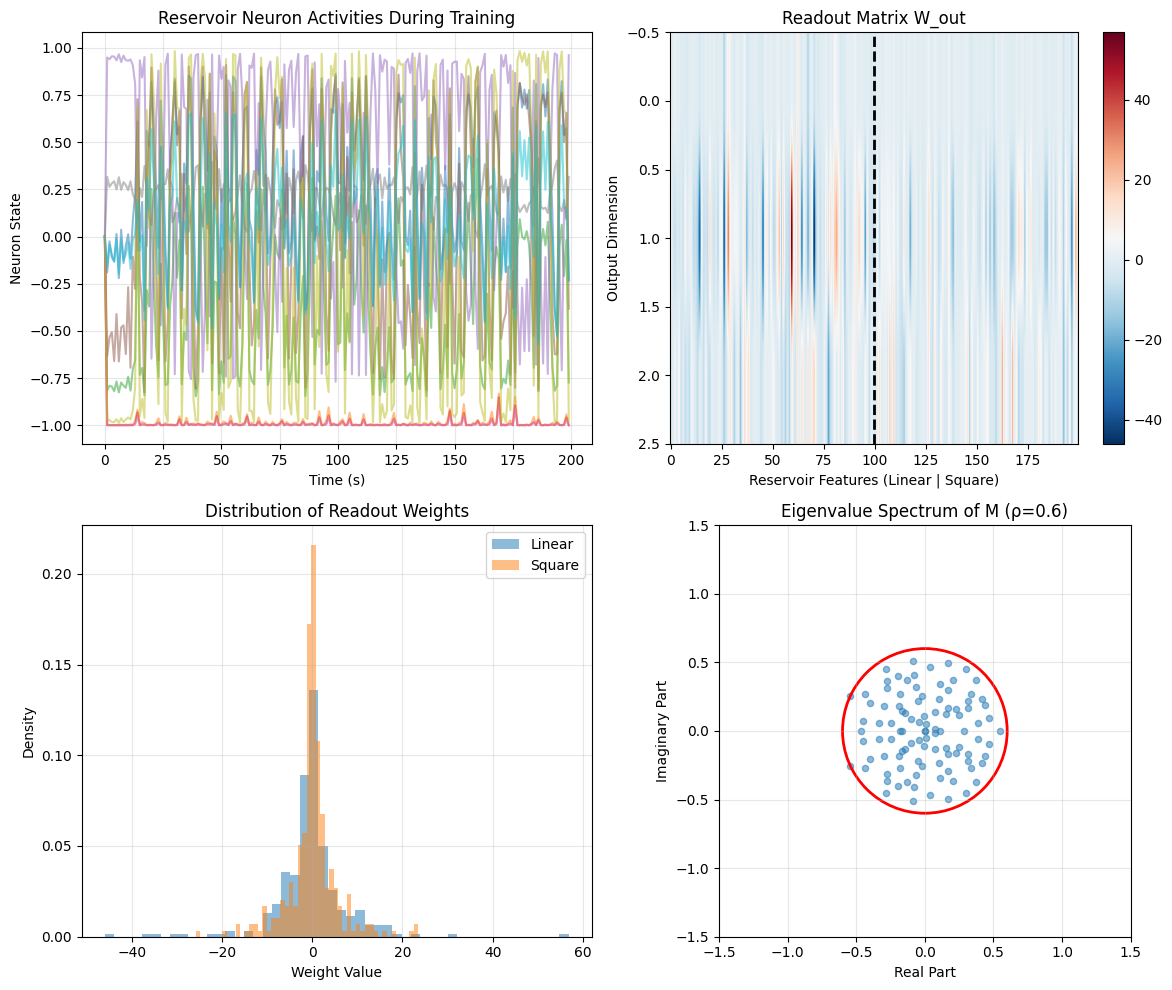

Statistics:
- Spectral radius: 0.6000
- Linear readout weights: mean=-0.2747, std=8.4178
- Square readout weights: mean=0.0251, std=5.5589
- Reservoir sparsity: 0.049


In [9]:
# Analyze the reservoir's internal dynamics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Reservoir state evolution during training
ax = axes[0, 0]
# Show first 10 neurons' activities
for i in range(min(10, rc.N)):
    ax.plot(t[:i_train:100], r_states[:i_train:100, i], alpha=0.5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Neuron State')
ax.set_title('Reservoir Neuron Activities During Training')
ax.grid(True, alpha=0.3)

# 2. Readout matrix visualization
ax = axes[0, 1]
im = ax.imshow(rc.W_out, aspect='auto', cmap='RdBu_r')
ax.set_xlabel('Reservoir Features (Linear | Square)')
ax.set_ylabel('Output Dimension')
ax.set_title('Readout Matrix W_out')
ax.axvline(x=rc.N-0.5, color='k', linestyle='--', linewidth=2)
plt.colorbar(im, ax=ax)

# 3. Distribution of readout weights
ax = axes[1, 0]
ax.hist(rc.W_out_linear.flatten(), bins=50, alpha=0.5, label='Linear', density=True)
ax.hist(rc.W_out_square.flatten(), bins=50, alpha=0.5, label='Square', density=True)
ax.set_xlabel('Weight Value')
ax.set_ylabel('Density')
ax.set_title('Distribution of Readout Weights')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Eigenvalue spectrum of M
ax = axes[1, 1]
eigenvalues = np.linalg.eigvals(rc.M)
ax.scatter(eigenvalues.real, eigenvalues.imag, alpha=0.5, s=20)
circle = plt.Circle((0, 0), rc.spectral_radius, fill=False, color='r', linewidth=2)
ax.add_patch(circle)
ax.set_xlabel('Real Part')
ax.set_ylabel('Imaginary Part')
ax.set_title(f'Eigenvalue Spectrum of M (ρ={rc.spectral_radius})')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Statistics:")
print(f"- Spectral radius: {np.max(np.abs(eigenvalues)):.4f}")
print(f"- Linear readout weights: mean={np.mean(rc.W_out_linear):.4f}, "
      f"std={np.std(rc.W_out_linear):.4f}")
print(f"- Square readout weights: mean={np.mean(rc.W_out_square):.4f}, "
      f"std={np.std(rc.W_out_square):.4f}")
print(f"- Reservoir sparsity: {np.mean(rc.M != 0):.3f}")

In [ ]:
#def predicting_stage 